In [222]:
import os
import pandas as pd
from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms.functional as tx
import torchvision.transforms as T
import numpy as np
from torch import nn
from torchmetrics import Accuracy
from PIL import Image
import random
from sklearn.metrics import average_precision_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")

In [223]:
global_mean = [158.3856573864422, 114.90580952062017, 95.67717047497234]
global_std = [37.309381112669854, 36.328787789451965, 35.34503472225006]

In [224]:
class Mydataset():
    def __init__(self, csv_file, augment=False):
        self.df = pd.read_csv("../data/"+csv_file)
        self.augment = augment
        self.image_size = 256
        self.mean = np.array(global_mean)
        self.std = np.array(global_std)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        image_id = self.df["id"][idx]
        label = self.df["label"][idx]
        image = cv2.imread("../data/crop_nail_image/"+image_name)
        image = cv2.resize(image, dsize=(self.image_size, self.image_size), interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         plt.imshow(image)
#         plt.show()
#         image = self.reduce_flection(image)
#         plt.imshow(image)
#         plt.show()
        image = Image.fromarray(image)
#         if self.augment:
#             image = augmentation(image)
        image = tx.to_tensor(image)
        image = tx.resize(image, (self.image_size, self.image_size))
        image = image[:,100:200,100:200]
        R = image[0]
        G = image[1]
        B = image[2]
#         print(R.shape)
        hist0, bin_edges0 = np.histogram(R, 256)
        hist1, bin_edges1 = np.histogram(G, 256)
        hist2, bin_edges2 = np.histogram(B, 256)
#         plt.plot(hist0)
        image_mean_R = torch.mean(R)
        image_mean_G = torch.mean(G)
        image_mean_B = torch.mean(B)
#         image = tx.normalize(image, self.mean/255, self.std/255) 
        return image, label, image_mean_R, image_mean_G, image_mean_B, hist0, hist1, hist2
    def reduce_flection(self, image):
        gray = cv2.cvtColor((np.uint8(image)), cv2.COLOR_BGR2GRAY)
        mask = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY)[1]
        result = cv2.inpaint(np.uint8(image), mask, 21, cv2.INPAINT_TELEA) 
        return result.copy()

In [225]:
train_dataset = Mydataset("train_csv", augment=False)
train_dataloader = DataLoader(train_dataset, batch_size = 8)
valid_dataset = Mydataset("valid_csv", augment=False)
valid_dataloader = DataLoader(valid_dataset, batch_size = 8)

In [226]:
image, label, image_mean_R, image_mean_G, image_mean_B, hist0, hist1, hist2 = next(iter(train_dataloader))

In [227]:
hist0.shape

torch.Size([8, 256])

In [229]:
train_X_R = []
train_X_G = []
train_X_B = []
train_Y = []
train_mean_R=[]
train_mean_G=[]
train_mean_B=[]
for i, (image, label, image_mean_R, image_mean_G, image_mean_B, hist0, hist1, hist2) in enumerate(train_dataloader):
    for j in range(image.shape[0]):
        train_X_R.append(np.array(hist0[j]))
        train_X_G.append(np.array(hist1[j]))
        train_X_B.append(np.array(hist2[j]))
        train_Y.append(np.array(label[j]))
        train_mean_R.append(image_mean_R[j])
        train_mean_G.append(image_mean_G[j])
        train_mean_B.append(image_mean_B[j])
valid_X_R = []
valid_X_G = []
valid_X_B = []
valid_Y = []
valid_mean_R=[]
valid_mean_G=[]
valid_mean_B=[]
for i, (image, label, image_mean_R, image_mean_G, image_mean_B, hist0, hist1, hist2) in enumerate(valid_dataloader):
    for j in range(image.shape[0]):
        valid_X_R.append(np.array(hist0[j]))
        valid_X_G.append(np.array(hist1[j]))
        valid_X_B.append(np.array(hist2[j]))
        valid_Y.append(np.array(label[j]))
        valid_mean_R.append(image_mean_R[j])
        valid_mean_G.append(image_mean_G[j])
        valid_mean_B.append(image_mean_B[j])

In [230]:
np.array(train_X_R).shape

(385, 256)

In [231]:

# train_data_X_R = np.array(train_X_R).reshape(train_data_X_R.shape[0],1)
# train_data_X_G = np.array(train_X_G).reshape(train_data_X_G.shape[0],1)
# train_data_X_B = np.array(train_X_B).reshape(train_data_X_B.shape[0],1)
# train_data_Y = np.array(train_Y).reshape(train_data_Y.shape[0],1)
# valid_data_X_R = np.array(valid_X_R).reshape(valid_data_X_R.shape[0],1)
# valid_data_X_G = np.array(valid_X_G).reshape(valid_data_X_G.shape[0],1)
# valid_data_X_B = np.array(valid_X_B).reshape(valid_data_X_B.shape[0],1)
# valid_data_Y = np.array(valid_Y).reshape(valid_data_Y.shape[0],1)
train_data_X_R = np.array(train_X_R)
train_data_X_G = np.array(train_X_G)
train_data_X_B = np.array(train_X_B)
train_data_Y = np.array(train_Y)
train_data_mean_R = np.array(train_mean_R).reshape(len(train_mean_R),1)
train_data_mean_G = np.array(train_mean_G).reshape(len(train_mean_G),1)
train_data_mean_B = np.array(train_mean_B).reshape(len(train_mean_B),1)
valid_data_X_R = np.array(valid_X_R)
valid_data_X_G = np.array(valid_X_G)
valid_data_X_B = np.array(valid_X_B)
valid_data_Y = np.array(valid_Y)
valid_data_mean_R = np.array(valid_mean_R).reshape(len(valid_mean_R),1)
valid_data_mean_G = np.array(valid_mean_G).reshape(len(valid_mean_G),1)
valid_data_mean_B = np.array(valid_mean_B).reshape(len(valid_mean_B),1)
print(train_data_X_R.shape)
print(train_data_Y.shape)
print(valid_data_X_R.shape)
print(valid_data_Y.shape)
print(valid_data_mean_R.shape)

(385, 256)
(385,)
(67, 256)
(67,)
(67, 1)


In [237]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()
train_data = np.concatenate((train_data_mean_R, train_data_mean_G, train_data_mean_B),axis=1)
valid_data = np.concatenate((valid_data_mean_R, valid_data_mean_G, valid_data_mean_B),axis=1)
model.fit(train_data, train_data_Y)
pred = model.predict(train_data)
acc = 0
for i in range(len(pred)):
    if pred[i]==train_data_Y[i]:
        acc+=1
print("train : ", acc/len(pred))
pred = model.predict(valid_data)
acc = 0
for i in range(len(pred)):
    if pred[i]== valid_data_Y[i]:
        acc+=1
print("valid : ", acc/len(pred))

train :  0.5324675324675324
valid :  0.5074626865671642


In [167]:
from xgboost import XGBClassifier
max_depth = 11
lr = 0.001
model_R = XGBClassifier(n_estimators=100, max_depth = max_depth,learning_rate= lr)
model_G = XGBClassifier(n_estimators=100, max_depth = max_depth, learning_rate= lr)
model_B = XGBClassifier(n_estimators=100, max_depth = max_depth, learning_rate= lr)
model_R.fit(train_data_X_R, train_data_Y)
model_G.fit(train_data_X_G, train_data_Y)
model_B.fit(train_data_X_B, train_data_Y)

#prediction for traing data
pred_R = model_R.predict(train_data_X_R)
pred_G = model_G.predict(train_data_X_G)
pred_B = model_B.predict(train_data_X_B)
acc_R = 0
acc_G = 0
acc_B = 0
train_data_X = []
for i in range(len(pred_R)):
    arr = np.zeros((3))
    arr[0] = pred_R[i]
    arr[1] = pred_G[i]
    arr[2] = pred_B[i]
    if pred_R[i]==train_data_Y[i]:
        acc_R+=1
    if pred_G[i]==train_data_Y[i]:
        acc_G+=1
    if pred_B[i]==train_data_Y[i]:
        acc_B+=1
    train_data_X.append(arr)
print(acc_R/len(pred_R))
print(acc_G/len(pred_G))
print(acc_B/len(pred_B))



#prediction for valid data
pred_R = model_R.predict(valid_data_X_R)
pred_G = model_G.predict(valid_data_X_G)
pred_B = model_B.predict(valid_data_X_B)
acc_R = 0
acc_G = 0
acc_B = 0
valid_data_X = []
for i in range(len(pred_R)):
    arr = np.zeros((3))
    arr[0] = pred_R[i]
    arr[1] = pred_G[i]
    arr[2] = pred_B[i]
    if pred_R[i]==valid_data_Y[i]:
        acc_R+=1
    if pred_G[i]==valid_data_Y[i]:
        acc_G+=1
    if pred_B[i]==valid_data_Y[i]:
        acc_B+=1
    valid_data_X.append(arr)
print("R acc : ",acc_R/len(pred_R))
print("G acc : ",acc_G/len(pred_G))
print("B acc : ",acc_B/len(pred_B))

print("R recall : ",recall_score(pred_R, valid_data_Y))
print("G recall : ",recall_score(pred_G, valid_data_Y))
print("B recall : ",recall_score(pred_B, valid_data_Y))
print("R precision : ",precision_score(pred_R, valid_data_Y))
print("G precision : ",precision_score(pred_G, valid_data_Y))
print("B precision : ",precision_score(pred_B, valid_data_Y))
print("R f1 : ",f1_score(pred_R, valid_data_Y))
print("G f1 : ",f1_score(pred_G, valid_data_Y))
print("B f1 : ",f1_score(pred_B, valid_data_Y))



0.9246753246753247
0.9090909090909091
0.9012987012987013
R acc :  0.6417910447761194
G acc :  0.4925373134328358
B acc :  0.4626865671641791
R recall :  0.68
G recall :  0.4838709677419355
B recall :  0.44
R precision :  0.5151515151515151
G precision :  0.45454545454545453
B precision :  0.3333333333333333
R f1 :  0.5862068965517241
G f1 :  0.46874999999999994
B f1 :  0.37931034482758624


In [168]:
from sklearn.ensemble import RandomForestClassifier
max_depth = 5
n = 100
model_R = RandomForestClassifier(n_estimators=n, max_depth = max_depth)
model_G = RandomForestClassifier(n_estimators=n, max_depth = max_depth)
model_B = RandomForestClassifier(n_estimators=n, max_depth = max_depth)
model_R.fit(train_data_X_R, train_data_Y)
model_G.fit(train_data_X_G, train_data_Y)
model_B.fit(train_data_X_B, train_data_Y)

#prediction for traing data
pred_R = model_R.predict(train_data_X_R)
pred_G = model_G.predict(train_data_X_G)
pred_B = model_B.predict(train_data_X_B)
acc_R = 0
acc_G = 0
acc_B = 0
train_data_X = []
for i in range(len(pred_R)):
    arr = np.zeros((3))
    arr[0] = pred_R[i]
    arr[1] = pred_G[i]
    arr[2] = pred_B[i]
    if pred_R[i]==train_data_Y[i]:
        acc_R+=1
    if pred_G[i]==train_data_Y[i]:
        acc_G+=1
    if pred_B[i]==train_data_Y[i]:
        acc_B+=1
    train_data_X.append(arr)
print(acc_R/len(pred_R))
print(acc_G/len(pred_G))
print(acc_B/len(pred_B))



#prediction for valid data
pred_R = model_R.predict(valid_data_X_R)
pred_G = model_G.predict(valid_data_X_G)
pred_B = model_B.predict(valid_data_X_B)
acc_R = 0
acc_G = 0
acc_B = 0
valid_data_X = []
for i in range(len(pred_R)):
    arr = np.zeros((3))
    arr[0] = pred_R[i]
    arr[1] = pred_G[i]
    arr[2] = pred_B[i]
    if pred_R[i]==valid_data_Y[i]:
        acc_R+=1
    if pred_G[i]==valid_data_Y[i]:
        acc_G+=1
    if pred_B[i]==valid_data_Y[i]:
        acc_B+=1
    valid_data_X.append(arr)
print("R acc : ",acc_R/len(pred_R))
print("G acc : ",acc_G/len(pred_G))
print("B acc : ",acc_B/len(pred_B))

print("R recall : ",recall_score(pred_R, valid_data_Y))
print("G recall : ",recall_score(pred_G, valid_data_Y))
print("B recall : ",recall_score(pred_B, valid_data_Y))
print("R precision : ",precision_score(pred_R, valid_data_Y))
print("G precision : ",precision_score(pred_G, valid_data_Y))
print("B precision : ",precision_score(pred_B, valid_data_Y))
print("R f1 : ",f1_score(pred_R, valid_data_Y))
print("G f1 : ",f1_score(pred_G, valid_data_Y))
print("B f1 : ",f1_score(pred_B, valid_data_Y))





#combine RGB channel predtion
train_pred_R = model_R.predict(train_data_X_R)
train_pred_G = model_G.predict(train_data_X_G)
train_pred_B = model_B.predict(train_data_X_B)
train_X = []

for i in range(len(train_pred_R)):
    arr = np.zeros((3))
    arr[0] = train_pred_R[i]
    arr[1] = train_pred_G[i]
    arr[2] = train_pred_B[i]
    train_X.append(arr.copy())
model = RandomForestClassifier(n_estimators=n)
model.fit(np.array(train_X), train_data_Y)

pred = model.predict(valid_data_X)
acc=0
for i in range(len(pred)):
    if(pred[i]==valid_data_Y[i]):
        acc+=1

print("acc : ", acc/len(pred))
print("recall : ", recall_score(pred, valid_data_Y))
print("precision : ", precision_score(pred, valid_data_Y))
print("f1 : ", f1_score(pred, valid_data_Y))


0.8857142857142857
0.8701298701298701
0.8545454545454545
R acc :  0.47761194029850745
G acc :  0.5223880597014925
B acc :  0.5522388059701493
R recall :  0.4375
G recall :  0.52
B recall :  0.5652173913043478
R precision :  0.21212121212121213
G precision :  0.3939393939393939
B precision :  0.3939393939393939
R f1 :  0.2857142857142857
G f1 :  0.44827586206896547
B f1 :  0.4642857142857143
acc :  0.5074626865671642
recall :  0.5
precision :  0.6060606060606061
f1 :  0.5479452054794521


In [169]:
from sklearn.neighbors import KNeighborsClassifier
max_depth = 2
lr = 0.01
n_neighbors = 150
model_R = KNeighborsClassifier(n_neighbors=n_neighbors)
model_G = KNeighborsClassifier(n_neighbors=n_neighbors)
model_B = KNeighborsClassifier(n_neighbors=n_neighbors)
model_R.fit(train_data_X_R, train_data_Y)
model_G.fit(train_data_X_G, train_data_Y)
model_B.fit(train_data_X_B, train_data_Y)

#prediction for traing data
pred_R = model_R.predict(train_data_X_R)
pred_G = model_G.predict(train_data_X_G)
pred_B = model_B.predict(train_data_X_B)
acc_R = 0
acc_G = 0
acc_B = 0
train_data_X = []
for i in range(len(pred_R)):
    arr = np.zeros((3))
    arr[0] = pred_R[i]
    arr[1] = pred_G[i]
    arr[2] = pred_B[i]
    if pred_R[i]==train_data_Y[i]:
        acc_R+=1
    if pred_G[i]==train_data_Y[i]:
        acc_G+=1
    if pred_B[i]==train_data_Y[i]:
        acc_B+=1
    train_data_X.append(arr)
print(acc_R/len(pred_R))
print(acc_G/len(pred_G))
print(acc_B/len(pred_B))



#prediction for valid data
pred_R = model_R.predict(valid_data_X_R)
pred_G = model_G.predict(valid_data_X_G)
pred_B = model_B.predict(valid_data_X_B)
acc_R = 0
acc_G = 0
acc_B = 0
valid_data_X = []
for i in range(len(pred_R)):
    arr = np.zeros((3))
    arr[0] = pred_R[i]
    arr[1] = pred_G[i]
    arr[2] = pred_B[i]
    if pred_R[i]==valid_data_Y[i]:
        acc_R+=1
    if pred_G[i]==valid_data_Y[i]:
        acc_G+=1
    if pred_B[i]==valid_data_Y[i]:
        acc_B+=1
    valid_data_X.append(arr)
print("R acc : ",acc_R/len(pred_R))
print("G acc : ",acc_G/len(pred_G))
print("B acc : ",acc_B/len(pred_B))

print("R recall : ",recall_score(pred_R, valid_data_Y))
print("G recall : ",recall_score(pred_G, valid_data_Y))
print("B recall : ",recall_score(pred_B, valid_data_Y))
print("R precision : ",precision_score(pred_R, valid_data_Y))
print("G precision : ",precision_score(pred_G, valid_data_Y))
print("B precision : ",precision_score(pred_B, valid_data_Y))
print("R f1 : ",f1_score(pred_R, valid_data_Y))
print("G f1 : ",f1_score(pred_G, valid_data_Y))
print("B f1 : ",f1_score(pred_B, valid_data_Y))





#combine RGB channel predtion
# train_pred_R = model_R.predict(train_data_X_R)
# train_pred_G = model_G.predict(train_data_X_G)
# train_pred_B = model_B.predict(train_data_X_B)
# train_X = []

# for i in range(len(train_pred_R)):
#     arr = np.zeros((3))
#     arr[0] = train_pred_R[i]
#     arr[1] = train_pred_G[i]
#     arr[2] = train_pred_B[i]
#     train_X.append(arr.copy())
# model = KNeighborsClassifier(n_neighbors=n_neighbors)
# model.fit(np.array(train_X), train_data_Y)

# pred = model.predict(valid_data_X)
# acc=0
# for i in range(len(pred)):
#     if(pred[i]==valid_data_Y[i]):
#         acc+=1

# print(acc/len(pred))

0.4831168831168831
0.4831168831168831
0.4727272727272727
R acc :  0.4925373134328358
G acc :  0.5074626865671642
B acc :  0.5074626865671642
R recall :  0.4925373134328358
G recall :  0.5
B recall :  0.5
R precision :  1.0
G precision :  0.9393939393939394
B precision :  1.0
R f1 :  0.66
G f1 :  0.6526315789473685
B f1 :  0.6666666666666666


In [170]:
from sklearn import svm
max_depth = 2
lr = 0.001
n_neighbors = 15
C = 1
degree = 1
gamma = 0.2
# model_R = svm.SVC(kernel='poly', degree=degree, gamma='auto', C=C)
# model_G = svm.SVC(kernel='poly', degree=degree, gamma='auto', C=C)
# model_B = svm.SVC(kernel='poly', degree=degree, gamma='auto', C=C)
model_R = svm.SVC(kernel='rbf', gamma=gamma, C=C)
model_G = svm.SVC(kernel='rbf', gamma=gamma, C=C)
model_B = svm.SVC(kernel='rbf', gamma=gamma, C=C)
model_R.fit(train_data_X_R, train_data_Y)
model_G.fit(train_data_X_G, train_data_Y)
model_B.fit(train_data_X_B, train_data_Y)

#prediction for traing data
pred_R = model_R.predict(train_data_X_R)
pred_G = model_G.predict(train_data_X_G)
pred_B = model_B.predict(train_data_X_B)
acc_R = 0
acc_G = 0
acc_B = 0
train_data_X = []
for i in range(len(pred_R)):
    arr = np.zeros((3))
    arr[0] = pred_R[i]
    arr[1] = pred_G[i]
    arr[2] = pred_B[i]
    if pred_R[i]==train_data_Y[i]:
        acc_R+=1
    if pred_G[i]==train_data_Y[i]:
        acc_G+=1
    if pred_B[i]==train_data_Y[i]:
        acc_B+=1
    train_data_X.append(arr)
print(acc_R/len(pred_R))
print(acc_G/len(pred_G))
print(acc_B/len(pred_B))



#prediction for valid data
pred_R = model_R.predict(valid_data_X_R)
pred_G = model_G.predict(valid_data_X_G)
pred_B = model_B.predict(valid_data_X_B)
acc_R = 0
acc_G = 0
acc_B = 0
valid_data_X = []
for i in range(len(pred_R)):
    arr = np.zeros((3))
    arr[0] = pred_R[i]
    arr[1] = pred_G[i]
    arr[2] = pred_B[i]
    if pred_R[i]==valid_data_Y[i]:
        acc_R+=1
    if pred_G[i]==valid_data_Y[i]:
        acc_G+=1
    if pred_B[i]==valid_data_Y[i]:
        acc_B+=1
    valid_data_X.append(arr)
print("R acc : ",acc_R/len(pred_R))
print("G acc : ",acc_G/len(pred_G))
print("B acc : ",acc_B/len(pred_B))

print("R recall : ",recall_score(pred_R, valid_data_Y))
print("G recall : ",recall_score(pred_G, valid_data_Y))
print("B recall : ",recall_score(pred_B, valid_data_Y))
print("R precision : ",precision_score(pred_R, valid_data_Y))
print("G precision : ",precision_score(pred_G, valid_data_Y))
print("B precision : ",precision_score(pred_B, valid_data_Y))
print("R f1 : ",f1_score(pred_R, valid_data_Y))
print("G f1 : ",f1_score(pred_G, valid_data_Y))
print("B f1 : ",f1_score(pred_B, valid_data_Y))





# combine RGB channel predtion
train_pred_R = model_R.predict(train_data_X_R)
train_pred_G = model_G.predict(train_data_X_G)
train_pred_B = model_B.predict(train_data_X_B)
train_X = []

for i in range(len(train_pred_R)):
    arr = np.zeros((3))
    arr[0] = train_pred_R[i]
    arr[1] = train_pred_G[i]
    arr[2] = train_pred_B[i]
    train_X.append(arr.copy())
model= svm.SVC(kernel='rbf', gamma=gamma, C=C)
model.fit(np.array(train_X), train_data_Y)

pred = model.predict(valid_data_X)
acc=0
for i in range(len(pred)):
    if(pred[i]==valid_data_Y[i]):
        acc+=1

print("acc : ", acc/len(pred))
print("recall : ", recall_score(pred, valid_data_Y))
print("precision : ", precision_score(pred, valid_data_Y))
print("f1 : ", f1_score(pred, valid_data_Y))

1.0
1.0
1.0
R acc :  0.5074626865671642
G acc :  0.5074626865671642
B acc :  0.5074626865671642
R recall :  0.0
G recall :  0.0
B recall :  0.0
R precision :  0.0
G precision :  0.0
B precision :  0.0
R f1 :  0.0
G f1 :  0.0
B f1 :  0.0
acc :  0.5074626865671642
recall :  0.0
precision :  0.0
f1 :  0.0


In [239]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Dense(512, activation="relu")(inputs)
    x = layers.Dense(512, activation="relu")(inputs)
#     x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
#     x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
#     x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
#     x = layers.Dropout(0.5)(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)
model = make_model(3, 1)

In [282]:
opt = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(opt, "binary_crossentropy", metrics=["accuracy"])

In [283]:
# train_data = np.concatenate((train_data_X_G[:,200:250], train_data_mean_G),axis=1)
# valid_data = np.concatenate((valid_data_X_G[:,200:250], valid_data_mean_G),axis=1)
train_data = np.concatenate((train_data_mean_R, train_data_mean_G, train_data_mean_B),axis=1)
valid_data = np.concatenate((valid_data_mean_R, valid_data_mean_G, valid_data_mean_B),axis=1)
print(train_data.shape)
print(valid_data.shape)

(385, 3)
(67, 3)


In [284]:
history = model.fit(train_data, train_data_Y, validation_data=(valid_data, valid_data_Y), epochs = 5000)

Epoch 1/5000
13/13 [==============================] - 1s 23ms/step - loss: 0.6935 - accuracy: 0.4831 - val_loss: 0.6931 - val_accuracy: 0.5075
Epoch 2/5000
13/13 [==============================] - 0s 10ms/step - loss: 0.6927 - accuracy: 0.4935 - val_loss: 0.6932 - val_accuracy: 0.5075
Epoch 3/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6925 - accuracy: 0.5169 - val_loss: 0.6932 - val_accuracy: 0.5075
Epoch 4/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6926 - accuracy: 0.5351 - val_loss: 0.6932 - val_accuracy: 0.5075
Epoch 5/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6926 - accuracy: 0.5221 - val_loss: 0.6932 - val_accuracy: 0.5075
Epoch 6/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6919 - accuracy: 0.5558 - val_loss: 0.6933 - val_accuracy: 0.5075
Epoch 7/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6935 - accuracy: 0.5091 - val_loss: 0.6933 - val_accuracy: 0.5075
Epoc

13/13 [==============================] - 0s 8ms/step - loss: 0.6920 - accuracy: 0.5273 - val_loss: 0.6954 - val_accuracy: 0.5075
Epoch 59/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6925 - accuracy: 0.5299 - val_loss: 0.6946 - val_accuracy: 0.5075
Epoch 60/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6905 - accuracy: 0.5351 - val_loss: 0.6944 - val_accuracy: 0.5075
Epoch 61/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6911 - accuracy: 0.5299 - val_loss: 0.6948 - val_accuracy: 0.5075
Epoch 62/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6897 - accuracy: 0.5377 - val_loss: 0.6945 - val_accuracy: 0.5075
Epoch 63/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6901 - accuracy: 0.5325 - val_loss: 0.6943 - val_accuracy: 0.5075
Epoch 64/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6907 - accuracy: 0.5351 - val_loss: 0.6941 - val_accuracy: 0.5075
Epoch 65/5000

13/13 [==============================] - 0s 9ms/step - loss: 0.6882 - accuracy: 0.5325 - val_loss: 0.6957 - val_accuracy: 0.5075
Epoch 116/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6927 - accuracy: 0.5325 - val_loss: 0.6987 - val_accuracy: 0.5075
Epoch 117/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6921 - accuracy: 0.5325 - val_loss: 0.6988 - val_accuracy: 0.5075
Epoch 118/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6898 - accuracy: 0.5299 - val_loss: 0.6960 - val_accuracy: 0.5075
Epoch 119/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6929 - accuracy: 0.5299 - val_loss: 0.6954 - val_accuracy: 0.5075
Epoch 120/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6867 - accuracy: 0.5325 - val_loss: 0.6939 - val_accuracy: 0.5075
Epoch 121/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6907 - accuracy: 0.5325 - val_loss: 0.6938 - val_accuracy: 0.5075
Epoch 1

Epoch 172/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6855 - accuracy: 0.5558 - val_loss: 0.6870 - val_accuracy: 0.5970
Epoch 173/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6839 - accuracy: 0.5662 - val_loss: 0.6867 - val_accuracy: 0.5821
Epoch 174/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6827 - accuracy: 0.5688 - val_loss: 0.6894 - val_accuracy: 0.5821
Epoch 175/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6832 - accuracy: 0.5844 - val_loss: 0.7052 - val_accuracy: 0.5075
Epoch 176/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6943 - accuracy: 0.5377 - val_loss: 0.6996 - val_accuracy: 0.5224
Epoch 177/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6867 - accuracy: 0.5584 - val_loss: 0.6898 - val_accuracy: 0.5821
Epoch 178/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6844 - accuracy: 0.5766 - val_loss: 0.6893 - val_accuracy:

Epoch 229/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6739 - accuracy: 0.6052 - val_loss: 0.6872 - val_accuracy: 0.6418
Epoch 230/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6720 - accuracy: 0.5610 - val_loss: 0.6912 - val_accuracy: 0.5970
Epoch 231/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6660 - accuracy: 0.6052 - val_loss: 0.6878 - val_accuracy: 0.6418
Epoch 232/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6756 - accuracy: 0.5844 - val_loss: 0.6948 - val_accuracy: 0.5821
Epoch 233/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6730 - accuracy: 0.5792 - val_loss: 0.6901 - val_accuracy: 0.5821
Epoch 234/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6792 - accuracy: 0.5610 - val_loss: 0.7026 - val_accuracy: 0.5075
Epoch 235/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6814 - accuracy: 0.5584 - val_loss: 0.6974 - val_accuracy:

Epoch 286/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6697 - accuracy: 0.5792 - val_loss: 0.7050 - val_accuracy: 0.5672
Epoch 287/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6669 - accuracy: 0.5870 - val_loss: 0.6953 - val_accuracy: 0.6269
Epoch 288/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6851 - accuracy: 0.5766 - val_loss: 0.6929 - val_accuracy: 0.5970
Epoch 289/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6722 - accuracy: 0.5662 - val_loss: 0.7062 - val_accuracy: 0.5075
Epoch 290/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6868 - accuracy: 0.5221 - val_loss: 0.7005 - val_accuracy: 0.4776
Epoch 291/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6917 - accuracy: 0.5013 - val_loss: 0.7008 - val_accuracy: 0.4776
Epoch 292/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6875 - accuracy: 0.5273 - val_loss: 0.7042 - val_accuracy:

Epoch 343/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6651 - accuracy: 0.5844 - val_loss: 0.7072 - val_accuracy: 0.5672
Epoch 344/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6620 - accuracy: 0.5922 - val_loss: 0.7024 - val_accuracy: 0.5970
Epoch 345/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6744 - accuracy: 0.5714 - val_loss: 0.7002 - val_accuracy: 0.6119
Epoch 346/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6701 - accuracy: 0.5948 - val_loss: 0.7103 - val_accuracy: 0.5672
Epoch 347/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6796 - accuracy: 0.5481 - val_loss: 0.7103 - val_accuracy: 0.5075
Epoch 348/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6817 - accuracy: 0.5325 - val_loss: 0.7014 - val_accuracy: 0.5672
Epoch 349/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6651 - accuracy: 0.6000 - val_loss: 0.7035 - val_accuracy:

Epoch 400/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6566 - accuracy: 0.6052 - val_loss: 0.6961 - val_accuracy: 0.6418
Epoch 401/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6575 - accuracy: 0.6130 - val_loss: 0.6984 - val_accuracy: 0.6119
Epoch 402/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6614 - accuracy: 0.6026 - val_loss: 0.6962 - val_accuracy: 0.6119
Epoch 403/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6568 - accuracy: 0.6104 - val_loss: 0.6965 - val_accuracy: 0.6119
Epoch 404/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6539 - accuracy: 0.6026 - val_loss: 0.6974 - val_accuracy: 0.6418
Epoch 405/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6558 - accuracy: 0.6026 - val_loss: 0.6973 - val_accuracy: 0.5970
Epoch 406/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6607 - accuracy: 0.6104 - val_loss: 0.7003 - val_accuracy:

Epoch 457/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6554 - accuracy: 0.6260 - val_loss: 0.7066 - val_accuracy: 0.5821
Epoch 458/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6657 - accuracy: 0.5818 - val_loss: 0.7028 - val_accuracy: 0.6119
Epoch 459/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6553 - accuracy: 0.6156 - val_loss: 0.7104 - val_accuracy: 0.5373
Epoch 460/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6537 - accuracy: 0.6052 - val_loss: 0.7059 - val_accuracy: 0.5821
Epoch 461/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6699 - accuracy: 0.6104 - val_loss: 0.7077 - val_accuracy: 0.5672
Epoch 462/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6540 - accuracy: 0.6052 - val_loss: 0.7021 - val_accuracy: 0.5821
Epoch 463/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6572 - accuracy: 0.6052 - val_loss: 0.6992 - val_accuracy:

Epoch 514/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6527 - accuracy: 0.6208 - val_loss: 0.7070 - val_accuracy: 0.5821
Epoch 515/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6471 - accuracy: 0.6468 - val_loss: 0.7072 - val_accuracy: 0.5970
Epoch 516/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6495 - accuracy: 0.6338 - val_loss: 0.7079 - val_accuracy: 0.5970
Epoch 517/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6374 - accuracy: 0.6390 - val_loss: 0.7125 - val_accuracy: 0.5970
Epoch 518/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6518 - accuracy: 0.6156 - val_loss: 0.7125 - val_accuracy: 0.5821
Epoch 519/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6459 - accuracy: 0.6156 - val_loss: 0.7142 - val_accuracy: 0.5821
Epoch 520/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6612 - accuracy: 0.6000 - val_loss: 0.7094 - val_accuracy:

Epoch 571/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6514 - accuracy: 0.5974 - val_loss: 0.7125 - val_accuracy: 0.5970
Epoch 572/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6466 - accuracy: 0.6260 - val_loss: 0.7230 - val_accuracy: 0.5821
Epoch 573/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6662 - accuracy: 0.6052 - val_loss: 0.7128 - val_accuracy: 0.5970
Epoch 574/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6551 - accuracy: 0.6208 - val_loss: 0.7077 - val_accuracy: 0.5821
Epoch 575/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6530 - accuracy: 0.6260 - val_loss: 0.7243 - val_accuracy: 0.5672
Epoch 576/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6449 - accuracy: 0.6104 - val_loss: 0.7105 - val_accuracy: 0.5970
Epoch 577/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6412 - accuracy: 0.6442 - val_loss: 0.7104 - val_accuracy:

Epoch 628/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6520 - accuracy: 0.6364 - val_loss: 0.7053 - val_accuracy: 0.5970
Epoch 629/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6417 - accuracy: 0.6234 - val_loss: 0.7111 - val_accuracy: 0.6119
Epoch 630/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6441 - accuracy: 0.6286 - val_loss: 0.7170 - val_accuracy: 0.5970
Epoch 631/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6440 - accuracy: 0.6312 - val_loss: 0.7138 - val_accuracy: 0.5970
Epoch 632/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6373 - accuracy: 0.6286 - val_loss: 0.7116 - val_accuracy: 0.5970
Epoch 633/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6481 - accuracy: 0.6182 - val_loss: 0.7009 - val_accuracy: 0.5821
Epoch 634/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6504 - accuracy: 0.6234 - val_loss: 0.7258 - val_accuracy:

Epoch 685/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6473 - accuracy: 0.6052 - val_loss: 0.7009 - val_accuracy: 0.6119
Epoch 686/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6401 - accuracy: 0.6364 - val_loss: 0.7053 - val_accuracy: 0.5970
Epoch 687/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6328 - accuracy: 0.6390 - val_loss: 0.7024 - val_accuracy: 0.6119
Epoch 688/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6427 - accuracy: 0.6312 - val_loss: 0.7058 - val_accuracy: 0.5970
Epoch 689/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6357 - accuracy: 0.6442 - val_loss: 0.7179 - val_accuracy: 0.6119
Epoch 690/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6408 - accuracy: 0.6442 - val_loss: 0.7092 - val_accuracy: 0.5821
Epoch 691/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6317 - accuracy: 0.6468 - val_loss: 0.7130 - val_accuracy:

Epoch 742/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6490 - accuracy: 0.6052 - val_loss: 0.7095 - val_accuracy: 0.5522
Epoch 743/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6501 - accuracy: 0.6338 - val_loss: 0.7042 - val_accuracy: 0.5970
Epoch 744/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6397 - accuracy: 0.6416 - val_loss: 0.7072 - val_accuracy: 0.5821
Epoch 745/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6387 - accuracy: 0.6442 - val_loss: 0.7047 - val_accuracy: 0.5821
Epoch 746/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6365 - accuracy: 0.6390 - val_loss: 0.7163 - val_accuracy: 0.5970
Epoch 747/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6432 - accuracy: 0.6390 - val_loss: 0.7113 - val_accuracy: 0.5672
Epoch 748/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6360 - accuracy: 0.6234 - val_loss: 0.7123 - val_accuracy:

Epoch 799/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6359 - accuracy: 0.6416 - val_loss: 0.7165 - val_accuracy: 0.5672
Epoch 800/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6433 - accuracy: 0.6364 - val_loss: 0.7207 - val_accuracy: 0.5522
Epoch 801/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6327 - accuracy: 0.6364 - val_loss: 0.7344 - val_accuracy: 0.5970
Epoch 802/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6369 - accuracy: 0.6442 - val_loss: 0.7245 - val_accuracy: 0.5970
Epoch 803/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6437 - accuracy: 0.6260 - val_loss: 0.7220 - val_accuracy: 0.5672
Epoch 804/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6395 - accuracy: 0.6364 - val_loss: 0.7320 - val_accuracy: 0.5821
Epoch 805/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6322 - accuracy: 0.6571 - val_loss: 0.7281 - val_accuracy:

Epoch 856/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6383 - accuracy: 0.6364 - val_loss: 0.7207 - val_accuracy: 0.6119
Epoch 857/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6526 - accuracy: 0.6000 - val_loss: 0.7120 - val_accuracy: 0.5821
Epoch 858/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6448 - accuracy: 0.6286 - val_loss: 0.7196 - val_accuracy: 0.5522
Epoch 859/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6408 - accuracy: 0.6104 - val_loss: 0.7269 - val_accuracy: 0.5821
Epoch 860/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6404 - accuracy: 0.6468 - val_loss: 0.7111 - val_accuracy: 0.5821
Epoch 861/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6396 - accuracy: 0.6286 - val_loss: 0.7091 - val_accuracy: 0.5821
Epoch 862/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6302 - accuracy: 0.6519 - val_loss: 0.7259 - val_accuracy:

Epoch 913/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6312 - accuracy: 0.6519 - val_loss: 0.7212 - val_accuracy: 0.6119
Epoch 914/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6148 - accuracy: 0.6623 - val_loss: 0.7232 - val_accuracy: 0.6119
Epoch 915/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6242 - accuracy: 0.6519 - val_loss: 0.7321 - val_accuracy: 0.5821
Epoch 916/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6219 - accuracy: 0.6494 - val_loss: 0.7294 - val_accuracy: 0.5970
Epoch 917/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6285 - accuracy: 0.6364 - val_loss: 0.7234 - val_accuracy: 0.5821
Epoch 918/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6302 - accuracy: 0.6390 - val_loss: 0.7269 - val_accuracy: 0.5821
Epoch 919/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6408 - accuracy: 0.6156 - val_loss: 0.7280 - val_accuracy:

Epoch 970/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6594 - accuracy: 0.5688 - val_loss: 0.7398 - val_accuracy: 0.5672
Epoch 971/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6411 - accuracy: 0.6416 - val_loss: 0.7540 - val_accuracy: 0.5672
Epoch 972/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6302 - accuracy: 0.6442 - val_loss: 0.7410 - val_accuracy: 0.5970
Epoch 973/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6328 - accuracy: 0.6338 - val_loss: 0.7440 - val_accuracy: 0.5970
Epoch 974/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6354 - accuracy: 0.6494 - val_loss: 0.7325 - val_accuracy: 0.5821
Epoch 975/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6350 - accuracy: 0.6494 - val_loss: 0.7234 - val_accuracy: 0.5821
Epoch 976/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6275 - accuracy: 0.6286 - val_loss: 0.7188 - val_accuracy:

Epoch 1027/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6147 - accuracy: 0.6545 - val_loss: 0.7637 - val_accuracy: 0.5672
Epoch 1028/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6383 - accuracy: 0.6442 - val_loss: 0.7622 - val_accuracy: 0.5672
Epoch 1029/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6336 - accuracy: 0.6390 - val_loss: 0.7790 - val_accuracy: 0.5522
Epoch 1030/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6161 - accuracy: 0.6519 - val_loss: 0.7603 - val_accuracy: 0.5672
Epoch 1031/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6236 - accuracy: 0.6494 - val_loss: 0.7717 - val_accuracy: 0.5821
Epoch 1032/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6134 - accuracy: 0.6571 - val_loss: 0.7565 - val_accuracy: 0.5970
Epoch 1033/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6349 - accuracy: 0.6442 - val_loss: 0.7357 - val_ac

13/13 [==============================] - 0s 8ms/step - loss: 0.6160 - accuracy: 0.6390 - val_loss: 0.7943 - val_accuracy: 0.5821
Epoch 1084/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6158 - accuracy: 0.6519 - val_loss: 0.7917 - val_accuracy: 0.5522
Epoch 1085/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6130 - accuracy: 0.6519 - val_loss: 0.7804 - val_accuracy: 0.5970
Epoch 1086/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6195 - accuracy: 0.6571 - val_loss: 0.7805 - val_accuracy: 0.6119
Epoch 1087/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6264 - accuracy: 0.6338 - val_loss: 0.7920 - val_accuracy: 0.5224
Epoch 1088/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6282 - accuracy: 0.6286 - val_loss: 0.7747 - val_accuracy: 0.5522
Epoch 1089/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6211 - accuracy: 0.6286 - val_loss: 0.7810 - val_accuracy: 0.5672
E

13/13 [==============================] - 0s 9ms/step - loss: 0.6119 - accuracy: 0.6597 - val_loss: 0.8286 - val_accuracy: 0.5672
Epoch 1140/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6073 - accuracy: 0.6805 - val_loss: 0.8107 - val_accuracy: 0.5970
Epoch 1141/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5985 - accuracy: 0.6727 - val_loss: 0.8099 - val_accuracy: 0.5522
Epoch 1142/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6088 - accuracy: 0.6649 - val_loss: 0.8347 - val_accuracy: 0.5224
Epoch 1143/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6118 - accuracy: 0.6571 - val_loss: 0.8391 - val_accuracy: 0.5373
Epoch 1144/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6133 - accuracy: 0.6494 - val_loss: 0.8081 - val_accuracy: 0.5672
Epoch 1145/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6142 - accuracy: 0.6597 - val_loss: 0.8227 - val_accuracy: 0.5522
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5934 - accuracy: 0.6649 - val_loss: 0.8619 - val_accuracy: 0.5970
Epoch 1196/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5861 - accuracy: 0.6779 - val_loss: 0.8704 - val_accuracy: 0.5373
Epoch 1197/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6069 - accuracy: 0.6649 - val_loss: 0.8633 - val_accuracy: 0.5522
Epoch 1198/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5992 - accuracy: 0.6753 - val_loss: 0.8646 - val_accuracy: 0.5522
Epoch 1199/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5994 - accuracy: 0.6727 - val_loss: 0.8917 - val_accuracy: 0.5522
Epoch 1200/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6099 - accuracy: 0.6494 - val_loss: 0.8818 - val_accuracy: 0.5522
Epoch 1201/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5984 - accuracy: 0.6701 - val_loss: 0.8975 - val_accuracy: 0.5373
E

13/13 [==============================] - 0s 9ms/step - loss: 0.6144 - accuracy: 0.6545 - val_loss: 0.8659 - val_accuracy: 0.5522
Epoch 1252/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6176 - accuracy: 0.6571 - val_loss: 0.8887 - val_accuracy: 0.5672
Epoch 1253/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6157 - accuracy: 0.6416 - val_loss: 0.8804 - val_accuracy: 0.5672
Epoch 1254/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6219 - accuracy: 0.6312 - val_loss: 0.8815 - val_accuracy: 0.5970
Epoch 1255/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6138 - accuracy: 0.6519 - val_loss: 0.8740 - val_accuracy: 0.5522
Epoch 1256/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6077 - accuracy: 0.6545 - val_loss: 0.8868 - val_accuracy: 0.5672
Epoch 1257/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6149 - accuracy: 0.6468 - val_loss: 0.9174 - val_accuracy: 0.5522
E

13/13 [==============================] - 0s 9ms/step - loss: 0.6159 - accuracy: 0.6545 - val_loss: 0.9149 - val_accuracy: 0.5522
Epoch 1308/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6141 - accuracy: 0.6519 - val_loss: 0.8744 - val_accuracy: 0.5522
Epoch 1309/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6101 - accuracy: 0.6701 - val_loss: 0.9004 - val_accuracy: 0.5373
Epoch 1310/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6028 - accuracy: 0.6623 - val_loss: 0.8814 - val_accuracy: 0.5672
Epoch 1311/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6049 - accuracy: 0.6571 - val_loss: 0.8959 - val_accuracy: 0.5522
Epoch 1312/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6124 - accuracy: 0.6623 - val_loss: 0.9003 - val_accuracy: 0.5224
Epoch 1313/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6043 - accuracy: 0.6623 - val_loss: 0.9076 - val_accuracy: 0.5522
E

13/13 [==============================] - 0s 9ms/step - loss: 0.6346 - accuracy: 0.6390 - val_loss: 0.8264 - val_accuracy: 0.5522
Epoch 1364/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6263 - accuracy: 0.6390 - val_loss: 0.8583 - val_accuracy: 0.5821
Epoch 1365/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6174 - accuracy: 0.6597 - val_loss: 0.8344 - val_accuracy: 0.5522
Epoch 1366/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6119 - accuracy: 0.6442 - val_loss: 0.8530 - val_accuracy: 0.5821
Epoch 1367/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6139 - accuracy: 0.6494 - val_loss: 0.8542 - val_accuracy: 0.5522
Epoch 1368/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6154 - accuracy: 0.6442 - val_loss: 0.8549 - val_accuracy: 0.6119
Epoch 1369/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6194 - accuracy: 0.6519 - val_loss: 0.8532 - val_accuracy: 0.5522
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5929 - accuracy: 0.6675 - val_loss: 0.9721 - val_accuracy: 0.5224
Epoch 1420/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5922 - accuracy: 0.6727 - val_loss: 0.9579 - val_accuracy: 0.5672
Epoch 1421/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5988 - accuracy: 0.6675 - val_loss: 0.9839 - val_accuracy: 0.5373
Epoch 1422/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6534 - accuracy: 0.5844 - val_loss: 0.9474 - val_accuracy: 0.4776
Epoch 1423/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6194 - accuracy: 0.6494 - val_loss: 0.8575 - val_accuracy: 0.4925
Epoch 1424/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6328 - accuracy: 0.6545 - val_loss: 0.8819 - val_accuracy: 0.5373
Epoch 1425/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6097 - accuracy: 0.6571 - val_loss: 0.9421 - val_accuracy: 0.5224
E

13/13 [==============================] - 0s 9ms/step - loss: 0.6481 - accuracy: 0.6364 - val_loss: 0.7475 - val_accuracy: 0.6119
Epoch 1476/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6432 - accuracy: 0.6416 - val_loss: 0.7445 - val_accuracy: 0.5672
Epoch 1477/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6350 - accuracy: 0.6364 - val_loss: 0.7450 - val_accuracy: 0.5672
Epoch 1478/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6410 - accuracy: 0.6416 - val_loss: 0.7450 - val_accuracy: 0.5672
Epoch 1479/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6408 - accuracy: 0.6416 - val_loss: 0.7449 - val_accuracy: 0.5821
Epoch 1480/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6347 - accuracy: 0.6545 - val_loss: 0.7434 - val_accuracy: 0.5672
Epoch 1481/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6374 - accuracy: 0.6364 - val_loss: 0.7414 - val_accuracy: 0.5672
E

13/13 [==============================] - 0s 9ms/step - loss: 0.6041 - accuracy: 0.6597 - val_loss: 0.9190 - val_accuracy: 0.5224
Epoch 1532/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6019 - accuracy: 0.6519 - val_loss: 0.8910 - val_accuracy: 0.5373
Epoch 1533/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6059 - accuracy: 0.6468 - val_loss: 0.9219 - val_accuracy: 0.5373
Epoch 1534/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6195 - accuracy: 0.6416 - val_loss: 0.8916 - val_accuracy: 0.5373
Epoch 1535/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5971 - accuracy: 0.6623 - val_loss: 0.8990 - val_accuracy: 0.5522
Epoch 1536/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6022 - accuracy: 0.6623 - val_loss: 0.9777 - val_accuracy: 0.5373
Epoch 1537/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6022 - accuracy: 0.6597 - val_loss: 0.9377 - val_accuracy: 0.5373
E

13/13 [==============================] - 0s 9ms/step - loss: 0.6079 - accuracy: 0.6623 - val_loss: 0.7646 - val_accuracy: 0.5373
Epoch 1588/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6196 - accuracy: 0.6390 - val_loss: 0.7645 - val_accuracy: 0.5522
Epoch 1589/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6399 - accuracy: 0.6156 - val_loss: 0.7939 - val_accuracy: 0.5672
Epoch 1590/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6325 - accuracy: 0.6156 - val_loss: 0.7569 - val_accuracy: 0.5970
Epoch 1591/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6347 - accuracy: 0.6286 - val_loss: 0.7499 - val_accuracy: 0.5373
Epoch 1592/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6168 - accuracy: 0.6727 - val_loss: 0.7490 - val_accuracy: 0.5970
Epoch 1593/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6128 - accuracy: 0.6701 - val_loss: 0.7547 - val_accuracy: 0.5821
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5960 - accuracy: 0.6701 - val_loss: 0.8468 - val_accuracy: 0.5970
Epoch 1644/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5969 - accuracy: 0.6675 - val_loss: 0.8705 - val_accuracy: 0.5522
Epoch 1645/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6043 - accuracy: 0.6545 - val_loss: 0.8051 - val_accuracy: 0.5821
Epoch 1646/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6053 - accuracy: 0.6779 - val_loss: 0.7878 - val_accuracy: 0.5373
Epoch 1647/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6114 - accuracy: 0.6649 - val_loss: 0.7600 - val_accuracy: 0.5522
Epoch 1648/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5953 - accuracy: 0.6857 - val_loss: 0.7509 - val_accuracy: 0.5522
Epoch 1649/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5875 - accuracy: 0.6857 - val_loss: 0.7249 - val_accuracy: 0.5672
E

13/13 [==============================] - 0s 9ms/step - loss: 0.6065 - accuracy: 0.6130 - val_loss: 0.9156 - val_accuracy: 0.4776
Epoch 1700/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6131 - accuracy: 0.6052 - val_loss: 0.8743 - val_accuracy: 0.5075
Epoch 1701/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6132 - accuracy: 0.6052 - val_loss: 0.8378 - val_accuracy: 0.5224
Epoch 1702/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6247 - accuracy: 0.6156 - val_loss: 0.8105 - val_accuracy: 0.4925
Epoch 1703/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6277 - accuracy: 0.6078 - val_loss: 0.8404 - val_accuracy: 0.5224
Epoch 1704/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6193 - accuracy: 0.6026 - val_loss: 0.8633 - val_accuracy: 0.5224
Epoch 1705/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6116 - accuracy: 0.6104 - val_loss: 0.8705 - val_accuracy: 0.5075
E

13/13 [==============================] - 0s 8ms/step - loss: 0.5751 - accuracy: 0.6831 - val_loss: 0.8952 - val_accuracy: 0.5672
Epoch 1756/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5652 - accuracy: 0.6935 - val_loss: 0.8758 - val_accuracy: 0.5672
Epoch 1757/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5693 - accuracy: 0.6883 - val_loss: 0.9146 - val_accuracy: 0.5522
Epoch 1758/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5817 - accuracy: 0.6857 - val_loss: 0.9974 - val_accuracy: 0.5224
Epoch 1759/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5893 - accuracy: 0.6831 - val_loss: 0.8520 - val_accuracy: 0.5672
Epoch 1760/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5863 - accuracy: 0.6909 - val_loss: 0.8427 - val_accuracy: 0.5672
Epoch 1761/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5809 - accuracy: 0.7039 - val_loss: 0.9117 - val_accuracy: 0.5373
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5634 - accuracy: 0.7013 - val_loss: 1.0618 - val_accuracy: 0.5522
Epoch 1812/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5709 - accuracy: 0.6727 - val_loss: 1.0845 - val_accuracy: 0.5522
Epoch 1813/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5778 - accuracy: 0.6831 - val_loss: 0.9792 - val_accuracy: 0.5522
Epoch 1814/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5551 - accuracy: 0.7143 - val_loss: 0.9933 - val_accuracy: 0.5821
Epoch 1815/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5604 - accuracy: 0.7039 - val_loss: 1.0416 - val_accuracy: 0.5821
Epoch 1816/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5548 - accuracy: 0.7117 - val_loss: 1.0611 - val_accuracy: 0.5672
Epoch 1817/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5945 - accuracy: 0.7013 - val_loss: 1.1477 - val_accuracy: 0.5373
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5698 - accuracy: 0.7039 - val_loss: 1.0958 - val_accuracy: 0.5075
Epoch 1868/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5525 - accuracy: 0.7013 - val_loss: 1.0793 - val_accuracy: 0.5970
Epoch 1869/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5461 - accuracy: 0.7013 - val_loss: 1.0666 - val_accuracy: 0.5821
Epoch 1870/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5566 - accuracy: 0.7065 - val_loss: 1.0837 - val_accuracy: 0.5373
Epoch 1871/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5543 - accuracy: 0.7117 - val_loss: 1.1244 - val_accuracy: 0.5075
Epoch 1872/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.7183 - accuracy: 0.5922 - val_loss: 0.9875 - val_accuracy: 0.4478
Epoch 1873/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6894 - accuracy: 0.6338 - val_loss: 1.0619 - val_accuracy: 0.4776
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5849 - accuracy: 0.6935 - val_loss: 1.0495 - val_accuracy: 0.5224
Epoch 1924/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5642 - accuracy: 0.7039 - val_loss: 1.0801 - val_accuracy: 0.5373
Epoch 1925/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5721 - accuracy: 0.7091 - val_loss: 1.0955 - val_accuracy: 0.5075
Epoch 1926/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5748 - accuracy: 0.7039 - val_loss: 1.0524 - val_accuracy: 0.5672
Epoch 1927/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6265 - accuracy: 0.6312 - val_loss: 1.0803 - val_accuracy: 0.4627
Epoch 1928/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6444 - accuracy: 0.5974 - val_loss: 1.0508 - val_accuracy: 0.4627
Epoch 1929/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6281 - accuracy: 0.6104 - val_loss: 1.0838 - val_accuracy: 0.4627
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5924 - accuracy: 0.6312 - val_loss: 1.0887 - val_accuracy: 0.4328
Epoch 1980/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5846 - accuracy: 0.6649 - val_loss: 1.1396 - val_accuracy: 0.5373
Epoch 1981/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5851 - accuracy: 0.6727 - val_loss: 1.1703 - val_accuracy: 0.5075
Epoch 1982/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5865 - accuracy: 0.6519 - val_loss: 1.2388 - val_accuracy: 0.4776
Epoch 1983/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6601 - accuracy: 0.6182 - val_loss: 1.3351 - val_accuracy: 0.4627
Epoch 1984/5000
13/13 [==============================] - 0s 10ms/step - loss: 0.6548 - accuracy: 0.6494 - val_loss: 1.1515 - val_accuracy: 0.4776
Epoch 1985/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6052 - accuracy: 0.6909 - val_loss: 1.0628 - val_accuracy: 0.5075


13/13 [==============================] - 0s 9ms/step - loss: 0.5659 - accuracy: 0.7039 - val_loss: 1.1523 - val_accuracy: 0.5075
Epoch 2036/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5768 - accuracy: 0.6909 - val_loss: 1.1508 - val_accuracy: 0.5373
Epoch 2037/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5724 - accuracy: 0.6909 - val_loss: 1.1888 - val_accuracy: 0.5373
Epoch 2038/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5660 - accuracy: 0.7091 - val_loss: 1.1721 - val_accuracy: 0.5075
Epoch 2039/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5681 - accuracy: 0.7039 - val_loss: 1.2266 - val_accuracy: 0.5224
Epoch 2040/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5549 - accuracy: 0.7039 - val_loss: 1.2421 - val_accuracy: 0.4925
Epoch 2041/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5508 - accuracy: 0.7221 - val_loss: 1.2061 - val_accuracy: 0.5224
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5729 - accuracy: 0.6727 - val_loss: 1.0952 - val_accuracy: 0.5224
Epoch 2092/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5740 - accuracy: 0.6961 - val_loss: 1.0804 - val_accuracy: 0.5075
Epoch 2093/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5695 - accuracy: 0.6987 - val_loss: 1.1021 - val_accuracy: 0.5224
Epoch 2094/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6080 - accuracy: 0.6545 - val_loss: 1.0739 - val_accuracy: 0.5373
Epoch 2095/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5685 - accuracy: 0.6909 - val_loss: 1.1144 - val_accuracy: 0.5224
Epoch 2096/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5821 - accuracy: 0.7039 - val_loss: 1.0583 - val_accuracy: 0.5075
Epoch 2097/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5883 - accuracy: 0.6779 - val_loss: 1.1830 - val_accuracy: 0.5224
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5900 - accuracy: 0.6545 - val_loss: 1.2430 - val_accuracy: 0.5821
Epoch 2148/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5720 - accuracy: 0.6779 - val_loss: 1.3072 - val_accuracy: 0.5522
Epoch 2149/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5780 - accuracy: 0.6779 - val_loss: 1.2853 - val_accuracy: 0.5373
Epoch 2150/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5691 - accuracy: 0.6753 - val_loss: 1.3042 - val_accuracy: 0.5224
Epoch 2151/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5703 - accuracy: 0.6883 - val_loss: 1.2432 - val_accuracy: 0.4925
Epoch 2152/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5641 - accuracy: 0.7013 - val_loss: 1.3062 - val_accuracy: 0.4925
Epoch 2153/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5703 - accuracy: 0.6831 - val_loss: 1.3293 - val_accuracy: 0.5075
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5390 - accuracy: 0.7169 - val_loss: 1.3281 - val_accuracy: 0.5373
Epoch 2204/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5333 - accuracy: 0.7221 - val_loss: 1.3960 - val_accuracy: 0.5373
Epoch 2205/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5344 - accuracy: 0.7195 - val_loss: 1.4215 - val_accuracy: 0.5373
Epoch 2206/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5261 - accuracy: 0.7273 - val_loss: 1.4038 - val_accuracy: 0.5373
Epoch 2207/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5310 - accuracy: 0.7351 - val_loss: 1.3965 - val_accuracy: 0.5373
Epoch 2208/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5237 - accuracy: 0.7247 - val_loss: 1.3990 - val_accuracy: 0.5373
Epoch 2209/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5543 - accuracy: 0.6883 - val_loss: 1.2904 - val_accuracy: 0.4776
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5546 - accuracy: 0.7247 - val_loss: 1.2485 - val_accuracy: 0.5373
Epoch 2260/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5413 - accuracy: 0.7195 - val_loss: 1.3276 - val_accuracy: 0.5224
Epoch 2261/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5354 - accuracy: 0.7247 - val_loss: 1.4064 - val_accuracy: 0.5224
Epoch 2262/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5433 - accuracy: 0.7117 - val_loss: 1.4008 - val_accuracy: 0.5224
Epoch 2263/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5279 - accuracy: 0.7299 - val_loss: 1.4294 - val_accuracy: 0.5224
Epoch 2264/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5434 - accuracy: 0.7143 - val_loss: 1.4626 - val_accuracy: 0.5373
Epoch 2265/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5378 - accuracy: 0.7221 - val_loss: 1.4642 - val_accuracy: 0.5224
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5163 - accuracy: 0.7273 - val_loss: 1.6948 - val_accuracy: 0.5075
Epoch 2316/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5130 - accuracy: 0.7325 - val_loss: 1.7767 - val_accuracy: 0.4925
Epoch 2317/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5120 - accuracy: 0.7403 - val_loss: 1.7315 - val_accuracy: 0.5224
Epoch 2318/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5144 - accuracy: 0.7195 - val_loss: 1.7427 - val_accuracy: 0.5075
Epoch 2319/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5329 - accuracy: 0.7091 - val_loss: 1.8502 - val_accuracy: 0.4925
Epoch 2320/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5219 - accuracy: 0.7117 - val_loss: 1.8824 - val_accuracy: 0.4925
Epoch 2321/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6224 - accuracy: 0.6390 - val_loss: 1.5114 - val_accuracy: 0.4925
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5528 - accuracy: 0.6805 - val_loss: 1.9508 - val_accuracy: 0.5224
Epoch 2372/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5255 - accuracy: 0.7065 - val_loss: 1.9178 - val_accuracy: 0.4776
Epoch 2373/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5384 - accuracy: 0.7195 - val_loss: 1.9657 - val_accuracy: 0.5224
Epoch 2374/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5305 - accuracy: 0.7247 - val_loss: 1.8220 - val_accuracy: 0.4925
Epoch 2375/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4979 - accuracy: 0.7455 - val_loss: 1.8559 - val_accuracy: 0.5075
Epoch 2376/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5040 - accuracy: 0.7273 - val_loss: 1.8394 - val_accuracy: 0.5224
Epoch 2377/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5076 - accuracy: 0.7506 - val_loss: 1.9320 - val_accuracy: 0.5075
E

13/13 [==============================] - 0s 9ms/step - loss: 0.7420 - accuracy: 0.6753 - val_loss: 1.5625 - val_accuracy: 0.6269
Epoch 2428/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5822 - accuracy: 0.7013 - val_loss: 1.6526 - val_accuracy: 0.5821
Epoch 2429/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5521 - accuracy: 0.6935 - val_loss: 1.8803 - val_accuracy: 0.5522
Epoch 2430/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5140 - accuracy: 0.7091 - val_loss: 1.8898 - val_accuracy: 0.5672
Epoch 2431/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5038 - accuracy: 0.7273 - val_loss: 1.8191 - val_accuracy: 0.5522
Epoch 2432/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4921 - accuracy: 0.7351 - val_loss: 1.9358 - val_accuracy: 0.5522
Epoch 2433/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4996 - accuracy: 0.7325 - val_loss: 1.9300 - val_accuracy: 0.5821
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5159 - accuracy: 0.7325 - val_loss: 2.0088 - val_accuracy: 0.5373
Epoch 2484/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5201 - accuracy: 0.7377 - val_loss: 2.3983 - val_accuracy: 0.5522
Epoch 2485/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4866 - accuracy: 0.7377 - val_loss: 2.3229 - val_accuracy: 0.5373
Epoch 2486/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5324 - accuracy: 0.7065 - val_loss: 1.9529 - val_accuracy: 0.5075
Epoch 2487/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5053 - accuracy: 0.7351 - val_loss: 2.2379 - val_accuracy: 0.5224
Epoch 2488/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4967 - accuracy: 0.7584 - val_loss: 2.2949 - val_accuracy: 0.5224
Epoch 2489/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4956 - accuracy: 0.7351 - val_loss: 2.2400 - val_accuracy: 0.5373
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5873 - accuracy: 0.6779 - val_loss: 1.9817 - val_accuracy: 0.4627
Epoch 2540/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5936 - accuracy: 0.6727 - val_loss: 1.9512 - val_accuracy: 0.4627
Epoch 2541/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6073 - accuracy: 0.6208 - val_loss: 2.0019 - val_accuracy: 0.4776
Epoch 2542/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5975 - accuracy: 0.6571 - val_loss: 1.8552 - val_accuracy: 0.4627
Epoch 2543/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5919 - accuracy: 0.6649 - val_loss: 1.9169 - val_accuracy: 0.4627
Epoch 2544/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5891 - accuracy: 0.6727 - val_loss: 2.0593 - val_accuracy: 0.4627
Epoch 2545/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6004 - accuracy: 0.6545 - val_loss: 2.0605 - val_accuracy: 0.4925
E

13/13 [==============================] - 0s 9ms/step - loss: 0.6439 - accuracy: 0.6857 - val_loss: 1.7732 - val_accuracy: 0.5075
Epoch 2596/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5753 - accuracy: 0.7039 - val_loss: 2.2597 - val_accuracy: 0.4925
Epoch 2597/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5582 - accuracy: 0.6935 - val_loss: 1.9211 - val_accuracy: 0.5373
Epoch 2598/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6281 - accuracy: 0.6805 - val_loss: 2.0199 - val_accuracy: 0.5075
Epoch 2599/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.7708 - accuracy: 0.6442 - val_loss: 1.9083 - val_accuracy: 0.5075
Epoch 2600/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6857 - accuracy: 0.6727 - val_loss: 1.4847 - val_accuracy: 0.4776
Epoch 2601/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5844 - accuracy: 0.6649 - val_loss: 1.7373 - val_accuracy: 0.4925
E

13/13 [==============================] - 0s 9ms/step - loss: 0.6395 - accuracy: 0.6104 - val_loss: 1.4569 - val_accuracy: 0.5224
Epoch 2652/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6111 - accuracy: 0.6416 - val_loss: 1.2808 - val_accuracy: 0.5224
Epoch 2653/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6095 - accuracy: 0.6597 - val_loss: 1.4566 - val_accuracy: 0.5075
Epoch 2654/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5969 - accuracy: 0.6494 - val_loss: 1.5745 - val_accuracy: 0.5522
Epoch 2655/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5996 - accuracy: 0.6519 - val_loss: 1.5801 - val_accuracy: 0.5672
Epoch 2656/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5837 - accuracy: 0.6623 - val_loss: 1.6332 - val_accuracy: 0.5672
Epoch 2657/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5774 - accuracy: 0.6753 - val_loss: 1.6154 - val_accuracy: 0.5224
E

13/13 [==============================] - 0s 9ms/step - loss: 0.6412 - accuracy: 0.6130 - val_loss: 1.0316 - val_accuracy: 0.5522
Epoch 2708/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6379 - accuracy: 0.6208 - val_loss: 1.0872 - val_accuracy: 0.5522
Epoch 2709/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6308 - accuracy: 0.6208 - val_loss: 1.1008 - val_accuracy: 0.5373
Epoch 2710/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6215 - accuracy: 0.6234 - val_loss: 1.1380 - val_accuracy: 0.5224
Epoch 2711/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6183 - accuracy: 0.6364 - val_loss: 1.0996 - val_accuracy: 0.5373
Epoch 2712/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6253 - accuracy: 0.6364 - val_loss: 0.8894 - val_accuracy: 0.5373
Epoch 2713/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6393 - accuracy: 0.6494 - val_loss: 0.8776 - val_accuracy: 0.5373
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5858 - accuracy: 0.6701 - val_loss: 1.9190 - val_accuracy: 0.5672
Epoch 2764/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5954 - accuracy: 0.6494 - val_loss: 2.0247 - val_accuracy: 0.5672
Epoch 2765/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5911 - accuracy: 0.6494 - val_loss: 1.8770 - val_accuracy: 0.5224
Epoch 2766/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5801 - accuracy: 0.6805 - val_loss: 1.9917 - val_accuracy: 0.5821
Epoch 2767/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5888 - accuracy: 0.6675 - val_loss: 1.9812 - val_accuracy: 0.5224
Epoch 2768/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5841 - accuracy: 0.6805 - val_loss: 1.9815 - val_accuracy: 0.5075
Epoch 2769/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5840 - accuracy: 0.6935 - val_loss: 1.7260 - val_accuracy: 0.4925
E

13/13 [==============================] - 0s 8ms/step - loss: 0.5760 - accuracy: 0.6779 - val_loss: 2.1639 - val_accuracy: 0.5373
Epoch 2820/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5838 - accuracy: 0.6753 - val_loss: 2.1494 - val_accuracy: 0.5373
Epoch 2821/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5792 - accuracy: 0.7013 - val_loss: 2.1124 - val_accuracy: 0.5075
Epoch 2822/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5765 - accuracy: 0.6883 - val_loss: 2.2424 - val_accuracy: 0.5522
Epoch 2823/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5821 - accuracy: 0.6805 - val_loss: 2.0176 - val_accuracy: 0.5522
Epoch 2824/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5761 - accuracy: 0.6961 - val_loss: 1.7729 - val_accuracy: 0.5224
Epoch 2825/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5839 - accuracy: 0.6805 - val_loss: 1.7438 - val_accuracy: 0.5522
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5884 - accuracy: 0.6935 - val_loss: 1.7768 - val_accuracy: 0.4627
Epoch 2876/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5692 - accuracy: 0.6857 - val_loss: 2.1766 - val_accuracy: 0.5075
Epoch 2877/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5658 - accuracy: 0.6883 - val_loss: 2.2757 - val_accuracy: 0.5373
Epoch 2878/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5577 - accuracy: 0.7039 - val_loss: 2.2079 - val_accuracy: 0.5075
Epoch 2879/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5737 - accuracy: 0.6935 - val_loss: 2.1546 - val_accuracy: 0.5373
Epoch 2880/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5542 - accuracy: 0.7273 - val_loss: 2.2156 - val_accuracy: 0.5224
Epoch 2881/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5597 - accuracy: 0.7117 - val_loss: 2.3417 - val_accuracy: 0.5522
E

13/13 [==============================] - 0s 9ms/step - loss: 0.6144 - accuracy: 0.6260 - val_loss: 1.9660 - val_accuracy: 0.5373
Epoch 2932/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6010 - accuracy: 0.6701 - val_loss: 2.2969 - val_accuracy: 0.5522
Epoch 2933/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6817 - accuracy: 0.6052 - val_loss: 1.4221 - val_accuracy: 0.5522
Epoch 2934/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6373 - accuracy: 0.6416 - val_loss: 1.0969 - val_accuracy: 0.5970
Epoch 2935/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6337 - accuracy: 0.6545 - val_loss: 1.1631 - val_accuracy: 0.5224
Epoch 2936/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6131 - accuracy: 0.6779 - val_loss: 1.2165 - val_accuracy: 0.5224
Epoch 2937/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5986 - accuracy: 0.6779 - val_loss: 1.4433 - val_accuracy: 0.5224
E

13/13 [==============================] - 0s 9ms/step - loss: 0.6083 - accuracy: 0.6597 - val_loss: 1.1520 - val_accuracy: 0.5522
Epoch 2988/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6229 - accuracy: 0.6312 - val_loss: 1.1593 - val_accuracy: 0.5522
Epoch 2989/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6147 - accuracy: 0.6519 - val_loss: 1.2407 - val_accuracy: 0.5970
Epoch 2990/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6148 - accuracy: 0.6494 - val_loss: 1.0554 - val_accuracy: 0.5672
Epoch 2991/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6132 - accuracy: 0.6494 - val_loss: 1.0384 - val_accuracy: 0.5522
Epoch 2992/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6140 - accuracy: 0.6442 - val_loss: 1.1717 - val_accuracy: 0.5522
Epoch 2993/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6003 - accuracy: 0.6701 - val_loss: 1.2410 - val_accuracy: 0.5522
E

13/13 [==============================] - 0s 8ms/step - loss: 0.5554 - accuracy: 0.7143 - val_loss: 1.5056 - val_accuracy: 0.5224
Epoch 3044/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5318 - accuracy: 0.7247 - val_loss: 1.5043 - val_accuracy: 0.5522
Epoch 3045/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5479 - accuracy: 0.7143 - val_loss: 1.5825 - val_accuracy: 0.5373
Epoch 3046/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5396 - accuracy: 0.7221 - val_loss: 1.5237 - val_accuracy: 0.5373
Epoch 3047/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5436 - accuracy: 0.7299 - val_loss: 1.5396 - val_accuracy: 0.5522
Epoch 3048/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5566 - accuracy: 0.7221 - val_loss: 1.5639 - val_accuracy: 0.5522
Epoch 3049/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5620 - accuracy: 0.7117 - val_loss: 1.4677 - val_accuracy: 0.5373
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5589 - accuracy: 0.7143 - val_loss: 1.7848 - val_accuracy: 0.5373
Epoch 3100/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5504 - accuracy: 0.7091 - val_loss: 2.0427 - val_accuracy: 0.5373
Epoch 3101/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5419 - accuracy: 0.7169 - val_loss: 1.9206 - val_accuracy: 0.5224
Epoch 3102/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5515 - accuracy: 0.7143 - val_loss: 1.9338 - val_accuracy: 0.5075
Epoch 3103/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5515 - accuracy: 0.7221 - val_loss: 1.9056 - val_accuracy: 0.5224
Epoch 3104/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5641 - accuracy: 0.7065 - val_loss: 1.7858 - val_accuracy: 0.5373
Epoch 3105/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5558 - accuracy: 0.7169 - val_loss: 1.7606 - val_accuracy: 0.5373
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5323 - accuracy: 0.7403 - val_loss: 2.3042 - val_accuracy: 0.4925
Epoch 3156/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5302 - accuracy: 0.7273 - val_loss: 2.2041 - val_accuracy: 0.5224
Epoch 3157/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5316 - accuracy: 0.7169 - val_loss: 2.1128 - val_accuracy: 0.5373
Epoch 3158/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5275 - accuracy: 0.7299 - val_loss: 2.2876 - val_accuracy: 0.5075
Epoch 3159/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5232 - accuracy: 0.7377 - val_loss: 2.2044 - val_accuracy: 0.5224
Epoch 3160/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5180 - accuracy: 0.7325 - val_loss: 2.0544 - val_accuracy: 0.4925
Epoch 3161/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5376 - accuracy: 0.7247 - val_loss: 2.3179 - val_accuracy: 0.4925
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5536 - accuracy: 0.7065 - val_loss: 2.4868 - val_accuracy: 0.5224
Epoch 3212/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5492 - accuracy: 0.7247 - val_loss: 2.4293 - val_accuracy: 0.4925
Epoch 3213/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5415 - accuracy: 0.7325 - val_loss: 2.4239 - val_accuracy: 0.5075
Epoch 3214/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5446 - accuracy: 0.7273 - val_loss: 2.6389 - val_accuracy: 0.5075
Epoch 3215/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5409 - accuracy: 0.7325 - val_loss: 2.4527 - val_accuracy: 0.5075
Epoch 3216/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5402 - accuracy: 0.7299 - val_loss: 2.5557 - val_accuracy: 0.5075
Epoch 3217/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5378 - accuracy: 0.7273 - val_loss: 2.4492 - val_accuracy: 0.5075
E

13/13 [==============================] - 0s 8ms/step - loss: 0.5419 - accuracy: 0.6883 - val_loss: 2.4126 - val_accuracy: 0.5075
Epoch 3268/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5233 - accuracy: 0.7247 - val_loss: 2.6969 - val_accuracy: 0.4925
Epoch 3269/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5111 - accuracy: 0.7273 - val_loss: 2.6626 - val_accuracy: 0.4925
Epoch 3270/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5003 - accuracy: 0.7481 - val_loss: 3.0937 - val_accuracy: 0.4925
Epoch 3271/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5119 - accuracy: 0.7117 - val_loss: 3.1144 - val_accuracy: 0.4776
Epoch 3272/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5126 - accuracy: 0.7325 - val_loss: 3.0095 - val_accuracy: 0.4627
Epoch 3273/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5105 - accuracy: 0.7195 - val_loss: 3.1768 - val_accuracy: 0.4627
E

13/13 [==============================] - 0s 8ms/step - loss: 0.5134 - accuracy: 0.7247 - val_loss: 3.0070 - val_accuracy: 0.4776
Epoch 3324/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5977 - accuracy: 0.6545 - val_loss: 1.2672 - val_accuracy: 0.5224
Epoch 3325/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6110 - accuracy: 0.6519 - val_loss: 1.3292 - val_accuracy: 0.5373
Epoch 3326/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5865 - accuracy: 0.6675 - val_loss: 1.4469 - val_accuracy: 0.5373
Epoch 3327/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5583 - accuracy: 0.6727 - val_loss: 1.5294 - val_accuracy: 0.5373
Epoch 3328/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5418 - accuracy: 0.7065 - val_loss: 1.7269 - val_accuracy: 0.5075
Epoch 3329/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5471 - accuracy: 0.7065 - val_loss: 1.8356 - val_accuracy: 0.5224
E

13/13 [==============================] - 0s 9ms/step - loss: 0.4898 - accuracy: 0.7403 - val_loss: 2.5501 - val_accuracy: 0.5224
Epoch 3380/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5070 - accuracy: 0.7299 - val_loss: 2.7031 - val_accuracy: 0.4776
Epoch 3381/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4984 - accuracy: 0.7325 - val_loss: 2.5606 - val_accuracy: 0.5075
Epoch 3382/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5075 - accuracy: 0.7403 - val_loss: 2.8041 - val_accuracy: 0.4627
Epoch 3383/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4981 - accuracy: 0.7481 - val_loss: 2.7023 - val_accuracy: 0.5373
Epoch 3384/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4817 - accuracy: 0.7636 - val_loss: 2.8227 - val_accuracy: 0.5224
Epoch 3385/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4715 - accuracy: 0.7584 - val_loss: 2.7951 - val_accuracy: 0.5373
E

13/13 [==============================] - 0s 9ms/step - loss: 0.4516 - accuracy: 0.7766 - val_loss: 3.3644 - val_accuracy: 0.5075
Epoch 3436/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4467 - accuracy: 0.7740 - val_loss: 3.2141 - val_accuracy: 0.4925
Epoch 3437/5000
13/13 [==============================] - 0s 10ms/step - loss: 0.4403 - accuracy: 0.7818 - val_loss: 3.5403 - val_accuracy: 0.4925
Epoch 3438/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4651 - accuracy: 0.7610 - val_loss: 3.0734 - val_accuracy: 0.4925
Epoch 3439/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.4699 - accuracy: 0.7636 - val_loss: 3.5758 - val_accuracy: 0.5075
Epoch 3440/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4450 - accuracy: 0.7740 - val_loss: 3.3073 - val_accuracy: 0.5224
Epoch 3441/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4430 - accuracy: 0.7818 - val_loss: 3.3982 - val_accuracy: 0.5373


13/13 [==============================] - 0s 8ms/step - loss: 0.6948 - accuracy: 0.4857 - val_loss: 0.7154 - val_accuracy: 0.4776
Epoch 3492/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6989 - accuracy: 0.4779 - val_loss: 0.7154 - val_accuracy: 0.4776
Epoch 3493/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6873 - accuracy: 0.4883 - val_loss: 0.7178 - val_accuracy: 0.4776
Epoch 3494/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6839 - accuracy: 0.4779 - val_loss: 0.7204 - val_accuracy: 0.4627
Epoch 3495/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6758 - accuracy: 0.5013 - val_loss: 0.7166 - val_accuracy: 0.4925
Epoch 3496/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6769 - accuracy: 0.5013 - val_loss: 0.7176 - val_accuracy: 0.5224
Epoch 3497/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6698 - accuracy: 0.5013 - val_loss: 0.7245 - val_accuracy: 0.5075
E

13/13 [==============================] - 0s 9ms/step - loss: 0.6378 - accuracy: 0.5766 - val_loss: 0.8876 - val_accuracy: 0.5522
Epoch 3548/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6386 - accuracy: 0.5688 - val_loss: 0.9018 - val_accuracy: 0.5672
Epoch 3549/5000
13/13 [==============================] - 0s 10ms/step - loss: 0.6375 - accuracy: 0.6052 - val_loss: 0.9022 - val_accuracy: 0.5672
Epoch 3550/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6331 - accuracy: 0.5688 - val_loss: 0.9127 - val_accuracy: 0.5672
Epoch 3551/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6300 - accuracy: 0.5922 - val_loss: 0.9028 - val_accuracy: 0.5522
Epoch 3552/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6312 - accuracy: 0.5870 - val_loss: 0.9012 - val_accuracy: 0.5373
Epoch 3553/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6620 - accuracy: 0.5351 - val_loss: 0.8698 - val_accuracy: 0.4925


13/13 [==============================] - 0s 9ms/step - loss: 0.5710 - accuracy: 0.6701 - val_loss: 3.5224 - val_accuracy: 0.5522
Epoch 3604/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5629 - accuracy: 0.6727 - val_loss: 3.5166 - val_accuracy: 0.5522
Epoch 3605/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5798 - accuracy: 0.6519 - val_loss: 3.5001 - val_accuracy: 0.5522
Epoch 3606/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5647 - accuracy: 0.6649 - val_loss: 3.5102 - val_accuracy: 0.5672
Epoch 3607/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5622 - accuracy: 0.6623 - val_loss: 4.1099 - val_accuracy: 0.5672
Epoch 3608/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6255 - accuracy: 0.6701 - val_loss: 2.9311 - val_accuracy: 0.5522
Epoch 3609/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5891 - accuracy: 0.6571 - val_loss: 2.8021 - val_accuracy: 0.5672
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5368 - accuracy: 0.6753 - val_loss: 3.0176 - val_accuracy: 0.5373
Epoch 3660/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5585 - accuracy: 0.6727 - val_loss: 2.7681 - val_accuracy: 0.4925
Epoch 3661/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5493 - accuracy: 0.6857 - val_loss: 3.0548 - val_accuracy: 0.4925
Epoch 3662/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5353 - accuracy: 0.6727 - val_loss: 3.4071 - val_accuracy: 0.4478
Epoch 3663/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5256 - accuracy: 0.6883 - val_loss: 3.5398 - val_accuracy: 0.4627
Epoch 3664/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5498 - accuracy: 0.6779 - val_loss: 3.6033 - val_accuracy: 0.4179
Epoch 3665/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5499 - accuracy: 0.6597 - val_loss: 3.9943 - val_accuracy: 0.4627
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5351 - accuracy: 0.6935 - val_loss: 2.1991 - val_accuracy: 0.5075
Epoch 3716/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5353 - accuracy: 0.6857 - val_loss: 2.4443 - val_accuracy: 0.4776
Epoch 3717/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5196 - accuracy: 0.7065 - val_loss: 2.6506 - val_accuracy: 0.5224
Epoch 3718/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5053 - accuracy: 0.7247 - val_loss: 2.5793 - val_accuracy: 0.5075
Epoch 3719/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5039 - accuracy: 0.7377 - val_loss: 2.6996 - val_accuracy: 0.4627
Epoch 3720/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4841 - accuracy: 0.7403 - val_loss: 2.9479 - val_accuracy: 0.5075
Epoch 3721/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4975 - accuracy: 0.7377 - val_loss: 2.9803 - val_accuracy: 0.4627
E

13/13 [==============================] - 0s 9ms/step - loss: 0.6031 - accuracy: 0.6468 - val_loss: 1.2496 - val_accuracy: 0.4776
Epoch 3772/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5939 - accuracy: 0.6727 - val_loss: 1.1581 - val_accuracy: 0.4925
Epoch 3773/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5950 - accuracy: 0.6649 - val_loss: 1.2966 - val_accuracy: 0.5522
Epoch 3774/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6351 - accuracy: 0.6390 - val_loss: 1.2338 - val_accuracy: 0.5224
Epoch 3775/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5969 - accuracy: 0.6338 - val_loss: 1.1751 - val_accuracy: 0.4776
Epoch 3776/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5888 - accuracy: 0.6857 - val_loss: 1.2660 - val_accuracy: 0.5075
Epoch 3777/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5615 - accuracy: 0.6623 - val_loss: 1.2835 - val_accuracy: 0.4776
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5708 - accuracy: 0.6727 - val_loss: 1.8965 - val_accuracy: 0.5821
Epoch 3828/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5654 - accuracy: 0.6805 - val_loss: 1.7853 - val_accuracy: 0.5522
Epoch 3829/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5601 - accuracy: 0.6805 - val_loss: 1.8544 - val_accuracy: 0.5522
Epoch 3830/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6869 - accuracy: 0.6675 - val_loss: 2.0274 - val_accuracy: 0.5821
Epoch 3831/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6202 - accuracy: 0.6390 - val_loss: 1.9238 - val_accuracy: 0.5224
Epoch 3832/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6174 - accuracy: 0.6312 - val_loss: 1.6079 - val_accuracy: 0.5672
Epoch 3833/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6059 - accuracy: 0.6286 - val_loss: 1.8052 - val_accuracy: 0.5821
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5229 - accuracy: 0.7039 - val_loss: 2.3960 - val_accuracy: 0.5224
Epoch 3884/5000
13/13 [==============================] - 0s 10ms/step - loss: 0.5240 - accuracy: 0.7273 - val_loss: 2.5440 - val_accuracy: 0.5224
Epoch 3885/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4965 - accuracy: 0.7455 - val_loss: 2.5958 - val_accuracy: 0.5075
Epoch 3886/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4940 - accuracy: 0.7221 - val_loss: 2.5443 - val_accuracy: 0.5224
Epoch 3887/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.4962 - accuracy: 0.7455 - val_loss: 2.4372 - val_accuracy: 0.5522
Epoch 3888/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4893 - accuracy: 0.7377 - val_loss: 2.6178 - val_accuracy: 0.5373
Epoch 3889/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.4881 - accuracy: 0.7273 - val_loss: 2.7707 - val_accuracy: 0.5373


13/13 [==============================] - 0s 9ms/step - loss: 0.5148 - accuracy: 0.7013 - val_loss: 2.2066 - val_accuracy: 0.5522
Epoch 3940/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5113 - accuracy: 0.7039 - val_loss: 2.1368 - val_accuracy: 0.5672
Epoch 3941/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5696 - accuracy: 0.6623 - val_loss: 1.3149 - val_accuracy: 0.5821
Epoch 3942/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5859 - accuracy: 0.6857 - val_loss: 1.3474 - val_accuracy: 0.5970
Epoch 3943/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5798 - accuracy: 0.6494 - val_loss: 1.4023 - val_accuracy: 0.6119
Epoch 3944/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5748 - accuracy: 0.6519 - val_loss: 1.5478 - val_accuracy: 0.5821
Epoch 3945/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5660 - accuracy: 0.6623 - val_loss: 1.7226 - val_accuracy: 0.5970
E

13/13 [==============================] - 0s 9ms/step - loss: 0.4868 - accuracy: 0.7117 - val_loss: 3.3095 - val_accuracy: 0.5522
Epoch 3996/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5319 - accuracy: 0.7143 - val_loss: 2.9917 - val_accuracy: 0.5522
Epoch 3997/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5035 - accuracy: 0.7169 - val_loss: 3.0439 - val_accuracy: 0.5522
Epoch 3998/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4935 - accuracy: 0.7091 - val_loss: 2.9043 - val_accuracy: 0.5075
Epoch 3999/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4843 - accuracy: 0.7143 - val_loss: 3.1352 - val_accuracy: 0.5373
Epoch 4000/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.4833 - accuracy: 0.7273 - val_loss: 3.4491 - val_accuracy: 0.5373
Epoch 4001/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4804 - accuracy: 0.7299 - val_loss: 3.0549 - val_accuracy: 0.5522
E

13/13 [==============================] - 0s 9ms/step - loss: 0.6389 - accuracy: 0.6130 - val_loss: 0.8697 - val_accuracy: 0.5373
Epoch 4052/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6335 - accuracy: 0.5818 - val_loss: 0.8710 - val_accuracy: 0.5373
Epoch 4053/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6217 - accuracy: 0.6286 - val_loss: 0.8948 - val_accuracy: 0.5224
Epoch 4054/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6284 - accuracy: 0.6416 - val_loss: 0.9069 - val_accuracy: 0.5075
Epoch 4055/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6330 - accuracy: 0.6208 - val_loss: 0.8913 - val_accuracy: 0.5373
Epoch 4056/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6255 - accuracy: 0.6260 - val_loss: 0.8872 - val_accuracy: 0.5373
Epoch 4057/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6187 - accuracy: 0.6234 - val_loss: 0.8952 - val_accuracy: 0.5373
E

13/13 [==============================] - 0s 9ms/step - loss: 0.6227 - accuracy: 0.6390 - val_loss: 1.0945 - val_accuracy: 0.5522
Epoch 4108/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6188 - accuracy: 0.6312 - val_loss: 1.1346 - val_accuracy: 0.5373
Epoch 4109/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6141 - accuracy: 0.6416 - val_loss: 1.1815 - val_accuracy: 0.5075
Epoch 4110/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6138 - accuracy: 0.6494 - val_loss: 1.1958 - val_accuracy: 0.5075
Epoch 4111/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6109 - accuracy: 0.6468 - val_loss: 1.2491 - val_accuracy: 0.4925
Epoch 4112/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6144 - accuracy: 0.6338 - val_loss: 1.2672 - val_accuracy: 0.4925
Epoch 4113/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6160 - accuracy: 0.6468 - val_loss: 1.3070 - val_accuracy: 0.4925
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5844 - accuracy: 0.6753 - val_loss: 1.3143 - val_accuracy: 0.5522
Epoch 4164/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5979 - accuracy: 0.6545 - val_loss: 1.4935 - val_accuracy: 0.5970
Epoch 4165/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5811 - accuracy: 0.6727 - val_loss: 1.6752 - val_accuracy: 0.5373
Epoch 4166/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5648 - accuracy: 0.6805 - val_loss: 1.5980 - val_accuracy: 0.5075
Epoch 4167/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5627 - accuracy: 0.6701 - val_loss: 1.6461 - val_accuracy: 0.4925
Epoch 4168/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5793 - accuracy: 0.6701 - val_loss: 1.6707 - val_accuracy: 0.4925
Epoch 4169/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5633 - accuracy: 0.6753 - val_loss: 1.6339 - val_accuracy: 0.5075
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5845 - accuracy: 0.6883 - val_loss: 1.5620 - val_accuracy: 0.5224
Epoch 4220/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5988 - accuracy: 0.6961 - val_loss: 1.6536 - val_accuracy: 0.4776
Epoch 4221/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5845 - accuracy: 0.6805 - val_loss: 1.7507 - val_accuracy: 0.5075
Epoch 4222/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5871 - accuracy: 0.6597 - val_loss: 1.9164 - val_accuracy: 0.5224
Epoch 4223/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5860 - accuracy: 0.6649 - val_loss: 1.7367 - val_accuracy: 0.5075
Epoch 4224/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5887 - accuracy: 0.6779 - val_loss: 1.8708 - val_accuracy: 0.5373
Epoch 4225/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5839 - accuracy: 0.6831 - val_loss: 1.8979 - val_accuracy: 0.5075
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5772 - accuracy: 0.6883 - val_loss: 2.2069 - val_accuracy: 0.5522
Epoch 4276/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5709 - accuracy: 0.6779 - val_loss: 1.9098 - val_accuracy: 0.5224
Epoch 4277/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5786 - accuracy: 0.6753 - val_loss: 1.9703 - val_accuracy: 0.5224
Epoch 4278/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5750 - accuracy: 0.6675 - val_loss: 2.2287 - val_accuracy: 0.5373
Epoch 4279/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5770 - accuracy: 0.6571 - val_loss: 2.2808 - val_accuracy: 0.5821
Epoch 4280/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5717 - accuracy: 0.6675 - val_loss: 2.2027 - val_accuracy: 0.5821
Epoch 4281/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5713 - accuracy: 0.6753 - val_loss: 2.2529 - val_accuracy: 0.5522
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5999 - accuracy: 0.6545 - val_loss: 2.1993 - val_accuracy: 0.5970
Epoch 4332/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5693 - accuracy: 0.6857 - val_loss: 2.0914 - val_accuracy: 0.5075
Epoch 4333/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5547 - accuracy: 0.7221 - val_loss: 1.9581 - val_accuracy: 0.5373
Epoch 4334/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5664 - accuracy: 0.6935 - val_loss: 2.1352 - val_accuracy: 0.5075
Epoch 4335/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.7388 - accuracy: 0.5610 - val_loss: 2.1051 - val_accuracy: 0.3881
Epoch 4336/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6768 - accuracy: 0.5740 - val_loss: 1.9577 - val_accuracy: 0.5522
Epoch 4337/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6428 - accuracy: 0.5896 - val_loss: 1.2693 - val_accuracy: 0.5970
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5857 - accuracy: 0.7013 - val_loss: 0.8469 - val_accuracy: 0.5522
Epoch 4388/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5698 - accuracy: 0.7065 - val_loss: 0.8637 - val_accuracy: 0.5672
Epoch 4389/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5739 - accuracy: 0.6961 - val_loss: 0.8982 - val_accuracy: 0.5522
Epoch 4390/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5743 - accuracy: 0.6909 - val_loss: 0.8942 - val_accuracy: 0.5522
Epoch 4391/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5719 - accuracy: 0.7247 - val_loss: 0.9013 - val_accuracy: 0.5672
Epoch 4392/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5757 - accuracy: 0.7065 - val_loss: 0.9151 - val_accuracy: 0.5672
Epoch 4393/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5664 - accuracy: 0.7065 - val_loss: 0.9237 - val_accuracy: 0.5522
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5980 - accuracy: 0.6883 - val_loss: 1.1904 - val_accuracy: 0.5672
Epoch 4444/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5986 - accuracy: 0.7039 - val_loss: 1.2523 - val_accuracy: 0.5373
Epoch 4445/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5669 - accuracy: 0.7065 - val_loss: 1.3248 - val_accuracy: 0.5373
Epoch 4446/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5705 - accuracy: 0.7091 - val_loss: 1.4159 - val_accuracy: 0.5672
Epoch 4447/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5682 - accuracy: 0.7065 - val_loss: 1.4467 - val_accuracy: 0.5522
Epoch 4448/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5654 - accuracy: 0.6805 - val_loss: 1.4963 - val_accuracy: 0.5373
Epoch 4449/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5676 - accuracy: 0.7195 - val_loss: 1.5262 - val_accuracy: 0.5373
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5456 - accuracy: 0.7169 - val_loss: 1.0191 - val_accuracy: 0.5373
Epoch 4500/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.6000 - accuracy: 0.7013 - val_loss: 0.9324 - val_accuracy: 0.5821
Epoch 4501/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5987 - accuracy: 0.6961 - val_loss: 0.9738 - val_accuracy: 0.5522
Epoch 4502/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5802 - accuracy: 0.7221 - val_loss: 0.9954 - val_accuracy: 0.5672
Epoch 4503/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5783 - accuracy: 0.6857 - val_loss: 1.0019 - val_accuracy: 0.5522
Epoch 4504/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5918 - accuracy: 0.6935 - val_loss: 1.0075 - val_accuracy: 0.5522
Epoch 4505/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5759 - accuracy: 0.7065 - val_loss: 1.0134 - val_accuracy: 0.5672
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5288 - accuracy: 0.7195 - val_loss: 1.3872 - val_accuracy: 0.5672
Epoch 4556/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5015 - accuracy: 0.7377 - val_loss: 1.7933 - val_accuracy: 0.5373
Epoch 4557/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5085 - accuracy: 0.7455 - val_loss: 2.1900 - val_accuracy: 0.5821
Epoch 4558/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5896 - accuracy: 0.7169 - val_loss: 1.5583 - val_accuracy: 0.6418
Epoch 4559/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6543 - accuracy: 0.6519 - val_loss: 1.4089 - val_accuracy: 0.5821
Epoch 4560/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5881 - accuracy: 0.7065 - val_loss: 1.2450 - val_accuracy: 0.5672
Epoch 4561/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5949 - accuracy: 0.7039 - val_loss: 1.1622 - val_accuracy: 0.5522
E

13/13 [==============================] - 0s 9ms/step - loss: 0.4659 - accuracy: 0.7455 - val_loss: 1.8869 - val_accuracy: 0.5224
Epoch 4612/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5240 - accuracy: 0.6909 - val_loss: 2.1072 - val_accuracy: 0.5224
Epoch 4613/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5240 - accuracy: 0.7013 - val_loss: 1.9106 - val_accuracy: 0.5373
Epoch 4614/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5072 - accuracy: 0.7273 - val_loss: 2.0245 - val_accuracy: 0.5075
Epoch 4615/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5036 - accuracy: 0.7299 - val_loss: 2.0594 - val_accuracy: 0.4776
Epoch 4616/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5009 - accuracy: 0.7273 - val_loss: 2.0773 - val_accuracy: 0.4925
Epoch 4617/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4908 - accuracy: 0.7247 - val_loss: 2.0433 - val_accuracy: 0.5373
E

13/13 [==============================] - 0s 8ms/step - loss: 0.4680 - accuracy: 0.7740 - val_loss: 2.0626 - val_accuracy: 0.5672
Epoch 4668/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4614 - accuracy: 0.7610 - val_loss: 2.0312 - val_accuracy: 0.5522
Epoch 4669/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4519 - accuracy: 0.7636 - val_loss: 2.0876 - val_accuracy: 0.5224
Epoch 4670/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4530 - accuracy: 0.7532 - val_loss: 2.1715 - val_accuracy: 0.5373
Epoch 4671/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4364 - accuracy: 0.7740 - val_loss: 2.2409 - val_accuracy: 0.5075
Epoch 4672/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4869 - accuracy: 0.7688 - val_loss: 2.2960 - val_accuracy: 0.5224
Epoch 4673/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.4851 - accuracy: 0.7429 - val_loss: 2.1280 - val_accuracy: 0.5821
E

13/13 [==============================] - 0s 9ms/step - loss: 0.4455 - accuracy: 0.7818 - val_loss: 2.1720 - val_accuracy: 0.5224
Epoch 4724/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4334 - accuracy: 0.7740 - val_loss: 2.1859 - val_accuracy: 0.5224
Epoch 4725/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4210 - accuracy: 0.7662 - val_loss: 2.3365 - val_accuracy: 0.5075
Epoch 4726/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4717 - accuracy: 0.7351 - val_loss: 1.8710 - val_accuracy: 0.4478
Epoch 4727/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4782 - accuracy: 0.7636 - val_loss: 2.0402 - val_accuracy: 0.5373
Epoch 4728/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.7477 - accuracy: 0.6078 - val_loss: 1.7987 - val_accuracy: 0.4776
Epoch 4729/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.6674 - accuracy: 0.6052 - val_loss: 1.9031 - val_accuracy: 0.4627
E

13/13 [==============================] - 0s 9ms/step - loss: 0.4642 - accuracy: 0.7636 - val_loss: 1.8871 - val_accuracy: 0.4776
Epoch 4780/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4641 - accuracy: 0.7714 - val_loss: 1.9985 - val_accuracy: 0.4627
Epoch 4781/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4650 - accuracy: 0.7558 - val_loss: 1.9417 - val_accuracy: 0.4925
Epoch 4782/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5071 - accuracy: 0.7273 - val_loss: 1.7405 - val_accuracy: 0.5075
Epoch 4783/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.4782 - accuracy: 0.7662 - val_loss: 1.8591 - val_accuracy: 0.5075
Epoch 4784/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4806 - accuracy: 0.7584 - val_loss: 2.2046 - val_accuracy: 0.5224
Epoch 4785/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4636 - accuracy: 0.7584 - val_loss: 2.5008 - val_accuracy: 0.5224
E

13/13 [==============================] - 0s 9ms/step - loss: 0.4105 - accuracy: 0.7844 - val_loss: 2.3885 - val_accuracy: 0.5373
Epoch 4836/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4124 - accuracy: 0.7870 - val_loss: 2.5611 - val_accuracy: 0.5224
Epoch 4837/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4010 - accuracy: 0.7948 - val_loss: 2.7107 - val_accuracy: 0.5075
Epoch 4838/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.4064 - accuracy: 0.7870 - val_loss: 2.8075 - val_accuracy: 0.5522
Epoch 4839/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4029 - accuracy: 0.8078 - val_loss: 2.8631 - val_accuracy: 0.5224
Epoch 4840/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4018 - accuracy: 0.8078 - val_loss: 2.8624 - val_accuracy: 0.5373
Epoch 4841/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.4492 - accuracy: 0.7636 - val_loss: 2.4671 - val_accuracy: 0.4925
E

13/13 [==============================] - 0s 9ms/step - loss: 0.6197 - accuracy: 0.6286 - val_loss: 1.0885 - val_accuracy: 0.4328
Epoch 4892/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5845 - accuracy: 0.6286 - val_loss: 1.0375 - val_accuracy: 0.4776
Epoch 4893/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5988 - accuracy: 0.6286 - val_loss: 0.9374 - val_accuracy: 0.4627
Epoch 4894/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5982 - accuracy: 0.6468 - val_loss: 0.9481 - val_accuracy: 0.4776
Epoch 4895/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5916 - accuracy: 0.6494 - val_loss: 0.9788 - val_accuracy: 0.4627
Epoch 4896/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5778 - accuracy: 0.6753 - val_loss: 0.9981 - val_accuracy: 0.4776
Epoch 4897/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5744 - accuracy: 0.6519 - val_loss: 1.0058 - val_accuracy: 0.4776
E

13/13 [==============================] - 0s 9ms/step - loss: 0.5445 - accuracy: 0.6779 - val_loss: 1.2275 - val_accuracy: 0.4925
Epoch 4948/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5464 - accuracy: 0.6701 - val_loss: 1.2292 - val_accuracy: 0.4925
Epoch 4949/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5419 - accuracy: 0.6831 - val_loss: 1.2274 - val_accuracy: 0.4776
Epoch 4950/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5288 - accuracy: 0.7143 - val_loss: 1.2483 - val_accuracy: 0.5075
Epoch 4951/5000
13/13 [==============================] - 0s 8ms/step - loss: 0.5862 - accuracy: 0.6727 - val_loss: 1.3180 - val_accuracy: 0.5075
Epoch 4952/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5708 - accuracy: 0.6675 - val_loss: 1.3447 - val_accuracy: 0.5075
Epoch 4953/5000
13/13 [==============================] - 0s 9ms/step - loss: 0.5405 - accuracy: 0.6727 - val_loss: 1.3115 - val_accuracy: 0.5075
E

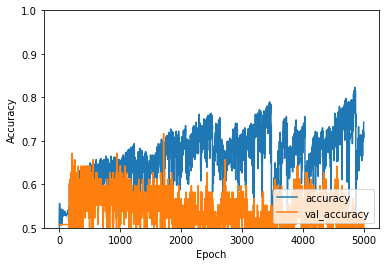

In [287]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [286]:
np.max(history.history['val_accuracy'])

0.7164179086685181